# Evaluación de arquitectura CNN autogenerada mediante Programación Genetica Cartesiana

### Alumno : Gustavo Ayrton Bitocchi
### Director : Diego Alexis Evin
### Universidad Austral Cohorte 2020/21
### Trabajo final de Maestria
------------------------------------------------------------------------------------------------------


## Bibliotecas

In [ ]:
# Importacion de bibliotecas

import random
import os
import cv2
import csv
import time
import math
import copy
import pickle
import traceback
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import boto3
import botocore

import multiprocessing.pool
import multiprocessing as mp

import torch
import torch.nn.parallel
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.transforms as tt
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.utils as vutils

from torch.nn import init
from torch.autograd import Variable
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from matplotlib.image import imread
from collections import OrderedDict
from cloudpathlib import CloudPath 

%matplotlib inline

## Definicion de clases que contienen implementacion de CNN generadas por CGP

In [ ]:
# Clase que representa bloque Convolucional     

class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel, stride):
        super(ConvBlock, self).__init__()
        pad_size = kernel // 2
        self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel, stride=stride, padding=pad_size, bias=False),
                                       nn.BatchNorm2d(out_size),
                                       nn.ReLU(inplace=True),)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        return outputs

# Clase que representa bloque Residual     

class ResBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel, stride):
        super(ResBlock, self).__init__()
        pad_size = kernel // 2
        self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, kernel, stride=stride, padding=pad_size, bias=False),
                                       nn.BatchNorm2d(out_size),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(out_size, out_size, kernel, stride=stride, padding=pad_size, bias=False),
                                       nn.BatchNorm2d(out_size))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs1, inputs2):
        x = self.conv1(inputs1)
        in_data = [x, inputs2]
        small_ch_id, large_ch_id = (0, 1) if in_data[0].size(1) < in_data[1].size(1) else (1, 0)
        offset = int(in_data[large_ch_id].size()[1] - in_data[small_ch_id].size()[1])
        if offset != 0:
            tmp = in_data[large_ch_id].data[:, :offset, :, :]
            tmp = Variable(tmp).clone()
            in_data[small_ch_id] = torch.cat([in_data[small_ch_id], tmp * 0], 1)
        out = torch.add(in_data[0], in_data[1])
        return self.relu(out)

# Clase que representa bloque Sum             

class Sum(nn.Module):
    def __init__(self):
        super(Sum, self).__init__()

    def forward(self, inputs1, inputs2):
        in_data = [inputs1, inputs2]
        if (in_data[0].size(2) - in_data[1].size(2)) != 0:
            small_in_id, large_in_id = (0, 1) if in_data[0].size(2) < in_data[1].size(2) else (1, 0)
            pool_num = math.floor(in_data[large_in_id].size(2) / in_data[small_in_id].size(2))
            for _ in range(pool_num-1):
                in_data[large_in_id] = F.max_pool2d(in_data[large_in_id], 2, 2, 0)
        small_ch_id, large_ch_id = (0, 1) if in_data[0].size(1) < in_data[1].size(1) else (1, 0)
        offset = int(in_data[large_ch_id].size()[1] - in_data[small_ch_id].size()[1])
        if offset != 0:
            tmp = in_data[large_ch_id].data[:, :offset, :, :]
            tmp = Variable(tmp).clone()
            in_data[small_ch_id] = torch.cat([in_data[small_ch_id], tmp * 0], 1)
        out = torch.add(in_data[0], in_data[1])
        return out

# Clase que representa bloque Concat        

class Concat(nn.Module):
    def __init__(self):
        super(Concat, self).__init__()

    def forward(self, inputs1, inputs2):
        in_data = [inputs1, inputs2]
        if (in_data[0].size(2) - in_data[1].size(2)) != 0:
            small_in_id, large_in_id = (0, 1) if in_data[0].size(2) < in_data[1].size(2) else (1, 0)
            pool_num = math.floor(in_data[large_in_id].size(2) / in_data[small_in_id].size(2))
            for _ in range(pool_num-1):
                in_data[large_in_id] = F.max_pool2d(in_data[large_in_id], 2, 2, 0)
        return torch.cat([in_data[0], in_data[1]], 1)

# Clase que transforma representacion CGP a CNN

class CGP_TO_CNN(nn.Module):
    def __init__(self, cgp):
        super(CGP_TO_CNN, self).__init__()
        self.cgp = cgp
        self.pool_size = 2
        self.arch = OrderedDict()
        self.encode = []
        self.channel_num = [None for _ in range(500)]
        self.size = [None for _ in range(500)]
        self.channel_num[0] = 3 # Cantidad de canales
        self.size[0] = 224 # Tamaño de la imagen
        i = 0
        for name, in1, in2 in self.cgp:
            if name == 'input' in name:
                i += 1
                continue
            elif name == 'full':
                self.encode.append(nn.Linear(self.channel_num[in1]*self.size[in1]*self.size[in1], 2))
            elif name == 'Max_Pool' or name == 'Avg_Pool':
                self.channel_num[i] = self.channel_num[in1]
                self.size[i] = int(self.size[in1] / 2)
                key = name.split('_')
                func = key[0]
                if func == 'Max':
                    self.encode.append(nn.MaxPool2d(2,2))
                else:
                    self.encode.append(nn.AvgPool2d(2,2))
            elif name == 'Concat':
                self.channel_num[i] = self.channel_num[in1] + self.channel_num[in2]
                small_in_id, large_in_id = (in1, in2) if self.size[in1] < self.size[in2] else (in2, in1)
                self.size[i] = self.size[small_in_id]
                self.encode.append(Concat())
            elif name == 'Sum':
                small_in_id, large_in_id = (in1, in2) if self.channel_num[in1] < self.channel_num[in2] else (in2, in1)
                self.channel_num[i] = self.channel_num[large_in_id]
                small_in_id, large_in_id = (in1, in2) if self.size[in1] < self.size[in2] else (in2, in1)
                self.size[i] = self.size[small_in_id]
                self.encode.append(Sum())
            else:
                key = name.split('_')
                down =     key[0]
                func =     key[1]
                out_size = int(key[2])
                kernel   = int(key[3])
                if down == 'S':
                    if func == 'ConvBlock':
                        self.channel_num[i] = out_size
                        self.size[i] = self.size[in1]
                        self.encode.append(ConvBlock(self.channel_num[in1], out_size, kernel, stride=1))
                    else:
                        in_data = [out_size, self.channel_num[in1]]
                        small_in_id, large_in_id = (0, 1) if in_data[0] < in_data[1] else (1, 0)
                        self.channel_num[i] = in_data[large_in_id]
                        self.size[i] = self.size[in1]
                        self.encode.append(ResBlock(self.channel_num[in1], out_size, kernel, stride=1))
                else:
                    sys.exit('Error')
            i += 1

        self.layer_module = nn.ModuleList(self.encode)
        self.outputs = [None for _ in range(len(self.cgp))]

    def main(self,x):
        outputs = self.outputs
        outputs[0] = x
        nodeID = 1
        for layer in self.layer_module:
            if isinstance(layer, ConvBlock):
                outputs[nodeID] = layer(outputs[self.cgp[nodeID][1]])
            elif isinstance(layer, ResBlock):
                outputs[nodeID] = layer(outputs[self.cgp[nodeID][1]], outputs[self.cgp[nodeID][1]])
            elif isinstance(layer, torch.nn.modules.linear.Linear):
                tmp = outputs[self.cgp[nodeID][1]].view(outputs[self.cgp[nodeID][1]].size(0), -1)
                outputs[nodeID] = layer(tmp)
            elif isinstance(layer, torch.nn.modules.pooling.MaxPool2d) or isinstance(layer, torch.nn.modules.pooling.AvgPool2d):
                if outputs[self.cgp[nodeID][1]].size(2) > 1:
                    outputs[nodeID] = layer(outputs[self.cgp[nodeID][1]])
                else:
                    outputs[nodeID] = outputs[self.cgp[nodeID][1]]
            elif isinstance(layer, Concat) or isinstance(layer, Sum):
                outputs[nodeID] = layer(outputs[self.cgp[nodeID][1]], outputs[self.cgp[nodeID][2]])
            else:
                sys.exit("Error")
            nodeID += 1
        return outputs[nodeID-1]

    def forward(self, x, t):
        return self.main(x)

## Lectura de modelo generado y conjunto de prueba

In [ ]:
# Cargamos modelo generado en GPU

model = torch.load('MODEL_FILE.pth')
model.cuda(0)
model.eval()

CGP2CNN(
  (layer_module): ModuleList(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (2): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
# Definimos tamaño del lote y cargamos conjunto de prueba

batch_size = 16

test_dataset = ImageFolder('TEST_DIRECTORY', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                 ]))

test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 2, shuffle = True, pin_memory = True)

## Estimacion de conjunto de prueba con modelo generado

In [ ]:
# Definimos funcion para evaluar conjunto de prueba

def test_predict(model, test_dataloader, batch_size):
  labels = []
  predictions = []
  
  for _, (data, target) in enumerate(test_dataloader):
    data = data.cuda(0)
    target = target.cuda(0)

    input = torch.FloatTensor(batch_size, 3, 224, 224)
    input = input.cuda(0)

    label = torch.LongTensor(batch_size)
    label = label.cuda(0)

    input.resize_as_(data).copy_(data)
    input_ = Variable(input)

    label.resize_as_(target).copy_(target)
    label_ = Variable(label)

    try:
      with torch.no_grad():
        output = model(input_, None)
    except:
      traceback.print_exc()
      return 0.

    _, predicted = torch.max(output.data, 1)
    label_ = label_.cpu()
    labels.extend(label_.data.tolist())
    predicted = predicted.cpu()
    predictions.extend(predicted.tolist())
        
  return predictions, labels

In [ ]:
# Evaluamos conjunto de prueba
prediction_start_time = time.time()

predictions, labels = test_predict(model, test_dataloader, batch_size)

prediction_end_time = time.time()

In [ ]:
# Obtenemos tiempo de evaluacion
print("Tiempo de evaluacion en segundos:", prediction_end_time - prediction_start_time)

## Obtencion de metricas y graficos de estimacion

<Figure size 432x288 with 0 Axes>

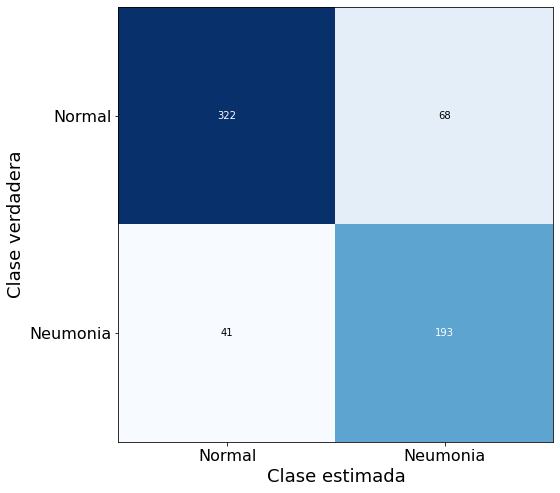

In [ ]:
# Realizamos matriz de confusion con los datos obtenidos de la estimacion

cm = confusion_matrix(labels, predictions)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Neumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Neumonia'], fontsize=16)
plt.xlabel('Clase estimada',fontsize=18)
plt.ylabel('Clase verdadera',fontsize=18)
plt.show()

In [ ]:
# Obtenemos metricas del conjunto de prueba

true_negatives, false_positives, false_negatives, true_positives = cm.ravel()

accuracy = (np.array(predictions) == np.array(labels)).sum() / len(predictions)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * ((precision * recall) / (precision + recall))
roc_auc = roc_auc_score(labels, predictions)

print("La exactitud del modelo es {:.2f}".format(accuracy))
print("El Recall del modelo es {:.2f}".format(recall))
print("La precision del modelo es {:.2f}".format(precision))
print("El F1 Score del modelo es {:.2f}".format(f1_score))
print("El AUC-ROC Score del modelo es {:.2f}".format(roc_auc))

La exactitud del modelo es 0.83
El Recall del modelo es 0.82
La precision del modelo es 0.74
El F1 Score del modelo es 0.78
El AUC-ROC Score del modelo es 0.83


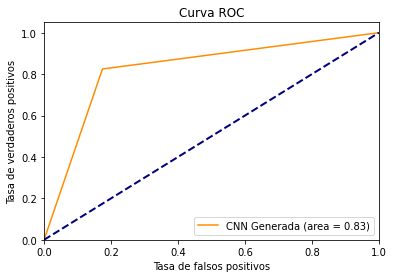

In [ ]:
# Graficamos curva ROC

false_positives_rate, true_positives_rate, _ = roc_curve(labels, predictions)

plt.figure(1)
lw = 2
plt.plot(false_positives_rate, true_positives_rate, color="darkorange", label="CNN Generada (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

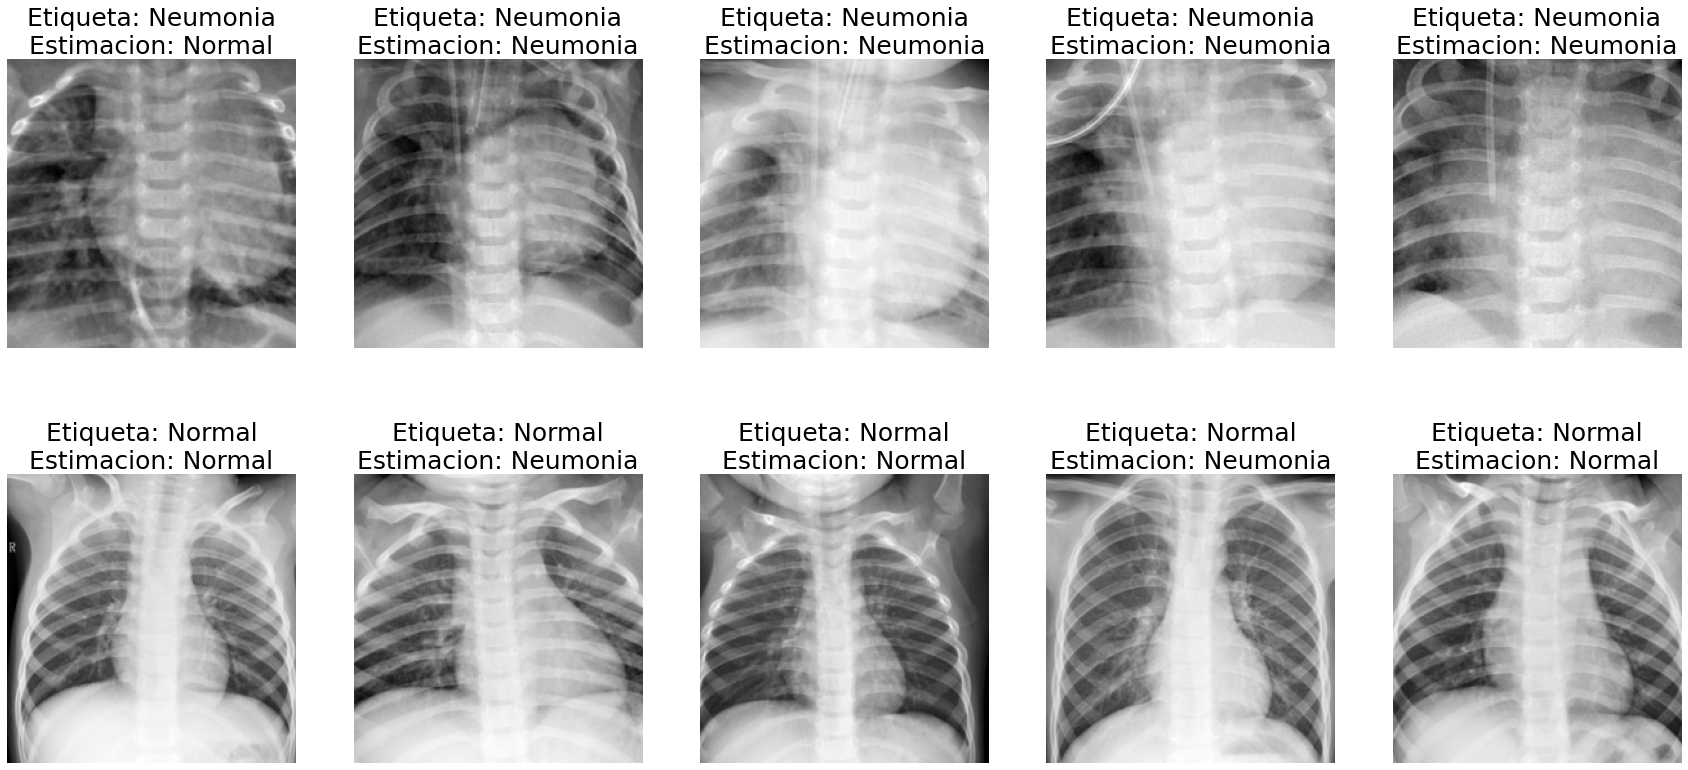

In [ ]:
# Visualizamos ejemplos de clase verdadera versus estimacion realizada por el modelo

idxs = torch.tensor(np.append(np.arange(start = 0, stop = 5, step = 1), np.arange(start = 500, stop = 505, step = 1))) 
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Etiqueta: {}\nEstimacion: {}'.format(test_dataset.classes[label], test_dataset.classes[predictions[i]]), fontsize=25)
    ax[c//5][c%5].axis('off')